In [47]:
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from UnderRandomForestClassifier import UnderRandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score

from imblearn.under_sampling import RandomUnderSampler

from utils import *

import warnings
warnings.filterwarnings('ignore')

EPS = 1E-8

np.random.seed(42)

## Function

## Parameter

In [48]:
ratio_test = 0.2

# Class imbalance factor 
fac_imb = 200       # N(0)/N(1)

# K-fold cross validation (CV)
K = 10

# Score for CV
scoring = {'WAcc': make_scorer(calc_WAcc, flag_balanced=True, weight=0.5)}

# Metrics for test
metric = {'Precision': precision_score, 
          'Recall':recall_score,
          'Weighted accuracy': lambda y_true, y: calc_WAcc(y_true, y, flag_balanced=True, weight=0.5),
          'Confusion Matrix': confusion_matrix,
         }

## Data preparation

In [49]:
feature, label = make_classification(n_samples = 20000,
                                     n_features = 10,
                                     n_informative = 6,
                                     n_redundant = 2,
                                     n_clusters_per_class = 1,
                                     weights = [fac_imb/(fac_imb+1), 1/(fac_imb+1)],
                                     class_sep = 1.0,
                                     shuffle = False,
                                    )

In [4]:
# pre-processing
ndata, ndim = feature.shape

In [5]:
# Class imbalance
fac_imb_real = np.sum(label == 0) / np.sum(label == 1)
print('N(y=0)/N(y=1) = {}'.format(fac_imb_real))

N(y=0)/N(y=1) = 94.69377990430623


In [6]:
# Split in training/test set
feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=ratio_test, random_state=17)

print('training: {0}, test: {1}'.format(feature_train.shape[0], feature_test.shape[0]))

training: 16000, test: 4000


## Feature importance (pre-training)

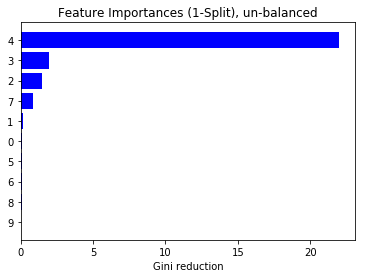

In [7]:
# Calc. gini index for each feature
#   Un-balanced class
ginis_feature_imb = calc_feature_importance(feature_train, label_train)

indices = np.argsort(ginis_feature_imb)
    
plt.title('Feature Importances (1-Split), un-balanced')
plt.barh(range(len(indices)), ginis_feature_imb[indices], color='b', align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Gini reduction')
plt.show()

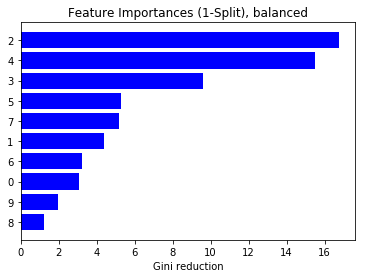

In [8]:
# Calc. gini index for each feature
#   Balanced class
rus = RandomUnderSampler(random_state=17)
feature_train_resampled, label_train_resampled = rus.fit_sample(feature_train, label_train)

ginis_feature_b = calc_feature_importance(feature_train_resampled, label_train_resampled)

indices = np.argsort(ginis_feature_b)
    
plt.title('Feature Importances (1-Split), balanced')
plt.barh(range(len(indices)), ginis_feature_b[indices], color='b', align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Gini reduction')
plt.show()

## Training

### Trial 1

Model：Decision Tree

Score：Weighted Accuracy

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:   12.1s finished


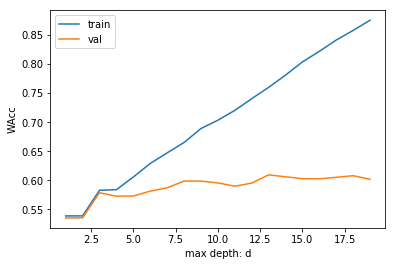

Optimal parameter: {'max_depth': 13}


In [9]:
# Grid-search for hyper-parameters using CV
cands_d = np.arange(1, 20)
param_grid = {'max_depth': cands_d}

clf = DecisionTreeClassifier(random_state=42)

gs = GridSearchCV(clf,
                  cv=K,
                  param_grid=param_grid,
                  scoring=scoring,
                  verbose=1,
                  n_jobs=-1,
                  refit=False)

gs.fit(feature_train, label_train)
res = gs.cv_results_

# plot
for name_plot, label_plot in (('train', 'train'), ('test', 'val')):
    plt.plot(param_grid['max_depth'], res['mean_{}_WAcc'.format(name_plot)], label=label_plot) 
plt.xlabel('max depth: d')
plt.ylabel(list(scoring)[0])
plt.legend()
plt.show()

# select best parameter
param_optim = res['params'][np.argmax(res['mean_test_WAcc'])]
d_optim = param_optim['max_depth']
print('Optimal parameter: {}'.format(param_optim))

In [26]:
# Fit model using all training data (without CV)
clf = DecisionTreeClassifier(**param_optim)

clf.fit(feature_train, label_train)

# Test
label_pred = clf.predict(feature_test)

for name, func in metric.items():
    print('{0}:\n {1}'.format(name, func(label_test, label_pred)))

Recall:
 0.23684210526315788
Precision:
 0.5
Weighted accuracy:
 0.6172852625941084
Confusion Matrix:
 [[3953    9]
 [  29    9]]


### Trial 2

Model：Decision Tree

       use class_weight to account for class imbalance

Score：Weighted Accuracy

Fitting 10 folds for each of 190 candidates, totalling 1900 fits


[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 358 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 1558 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1900 out of 1900 | elapsed:  1.9min finished


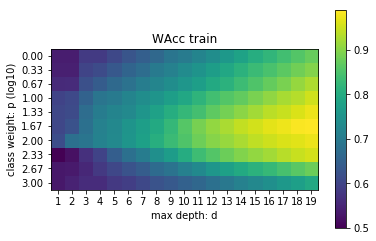

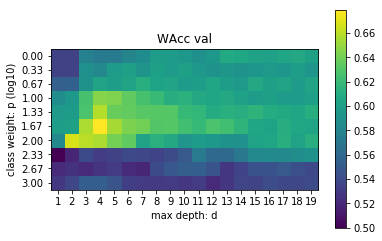

Optimal parameter: {'class_weight': {0: 1, 1: 46.41588833612777}, 'max_depth': 4}


In [28]:
# Grid-search for hyper-parameters using CV
cands_d = np.arange(1, 20)
cands_p = 10.0**np.linspace(0, 3, 10)
param_grid = {'max_depth': cands_d,
              'class_weight' : [ {0:1, 1:p} for p in cands_p ]}

clf = DecisionTreeClassifier(random_state=42)

gs = GridSearchCV(clf,
                  cv=K,
                  param_grid=param_grid,
                  scoring=scoring,
                  verbose=1,
                  n_jobs=-1,
                  refit=False)

gs.fit(feature_train, label_train)
res = gs.cv_results_

# plot
for name_plot, label_plot in (('train', 'train'), ('test', 'val')):
    plt.imshow(res['mean_{}_WAcc'.format(name_plot)].reshape((len(cands_p), len(cands_d))))
    plt.yticks(range(len(cands_p)), [ '{:.2f}'.format(np.log10(p)) for p in cands_p ])
    plt.xticks(range(len(cands_d)), cands_d)
    plt.xlabel('max depth: d')
    plt.ylabel('class weight: p (log10)')
    plt.colorbar()
    plt.title('WAcc {}'.format(label_plot))
    plt.show()


# select best parameter
param_optim = res['params'][np.argmax(res['mean_test_WAcc'])]
d_optim = param_optim['max_depth']
p_optim = param_optim['class_weight'][1]
print('Optimal parameter: {}'.format(param_optim))

In [30]:
# Fit model using all training data (without CV)
clf = DecisionTreeClassifier(**param_optim)

clf.fit(feature_train, label_train)

# Test
label_pred = clf.predict(feature_test)

for name, func in metric.items():
    print('{0}:\n {1}'.format(name, func(label_test, label_pred)))

Recall:
 0.39473684210526316
Precision:
 0.1171875
Weighted accuracy:
 0.6831079464916422
Confusion Matrix:
 [[3849  113]
 [  23   15]]


### Trial 2

Model：Random Forest

       use class_weight to account for class imbalance

Score：Weighted Accuracy

Fitting 10 folds for each of 70 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed: 19.7min finished


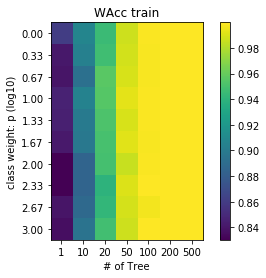

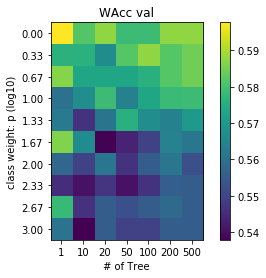

Optimal parameter: {'class_weight': {0: 1, 1: 1.0}, 'n_estimators': 1}


In [32]:
# Grid-search for hyper-parameters using CV
cands_T = np.array([1, 10, 20, 50, 100, 200, 500])
cands_p = 10.0**np.linspace(0, 3, 10)
param_grid = {'n_estimators': cands_T,
              'class_weight' : [ {0:1, 1:p} for p in cands_p ]}

clf = RandomForestClassifier()

gs = GridSearchCV(clf,
                  cv=K,
                  param_grid=param_grid,
                  scoring=scoring,
                  verbose=1,
                  n_jobs=-1,
                  refit=False)

gs.fit(feature_train, label_train)
res = gs.cv_results_

# plot
for name_plot, label_plot in (('train', 'train'), ('test', 'val')):
    plt.imshow(res['mean_{}_WAcc'.format(name_plot)].reshape((len(cands_p), len(cands_T))))
    plt.yticks(range(len(cands_p)), [ '{:.2f}'.format(np.log10(p)) for p in cands_p ])
    plt.xticks(range(len(cands_T)), cands_T)
    plt.xlabel('# of Tree')
    plt.ylabel('class weight: p (log10)')
    plt.colorbar()
    plt.title('WAcc {}'.format(label_plot))
    plt.show()


# select best parameter
param_optim = res['params'][np.argmax(res['mean_test_WAcc'])]
d_optim = param_optim['n_estimators']
p_optim = param_optim['class_weight'][1]
print('Optimal parameter: {}'.format(param_optim))

In [36]:
# Fit model using all training data (without CV)
clf = RandomForestClassifier(**param_optim)

clf.fit(feature_train, label_train)

# Test
label_pred = clf.predict(feature_test)

for name, func in metric.items():
    print('{0}:\n {1}'.format(name, func(label_test, label_pred)))

Recall:
 0.2894736842105263
Precision:
 0.2037037037037037
Weighted accuracy:
 0.6393102898195859
Confusion Matrix:
 [[3919   43]
 [  27   11]]


### Trial 3

Model：Random Forest

       Undersample dominant class (y=0) before each bootstrap to account for class imbalance

Score：Weighted Accuracy

Fitting 10 folds for each of 70 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 502 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed: 14.5min finished


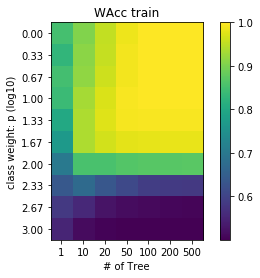

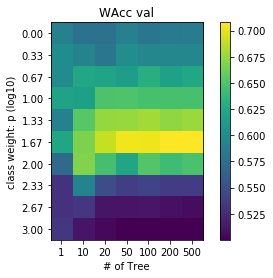

Optimal parameter: {'n_estimators': 200, 'undersample': 46.41588833612777}


In [38]:
# Grid-search for hyper-parameters using CV
cands_T = np.array([1, 10, 20, 50, 100, 200, 500])
cands_p = 10.0**np.linspace(0, 3, 10)
param_grid = {'n_estimators': cands_T,
              'undersample' : [ p for p in cands_p ]}

clf = UnderRandomForestClassifier()

gs = GridSearchCV(clf,
                  cv=K,
                  param_grid=param_grid,
                  scoring=scoring,
                  verbose=1,
                  n_jobs=-1,
                  refit=False)

gs.fit(feature_train, label_train)
res = gs.cv_results_


# plot
for name_plot, label_plot in (('train', 'train'), ('test', 'val')):
    plt.imshow(res['mean_{}_WAcc'.format(name_plot)].reshape((len(cands_T), len(cands_p))).T)
    plt.yticks(range(len(cands_p)), [ '{:.2f}'.format(np.log10(p)) for p in cands_p ])
    plt.xticks(range(len(cands_T)), cands_T)
    plt.xlabel('# of Tree')
    plt.ylabel('class weight: p (log10)')
    plt.colorbar()
    plt.title('WAcc {}'.format(label_plot))
    plt.show()


# select best parameter
param_optim = res['params'][np.argmax(res['mean_test_WAcc'])]
T_optim = param_optim['n_estimators']
p_optim = param_optim['undersample']
print('Optimal parameter: {}'.format(param_optim))

In [41]:
# Fit model using all training data (without CV)
clf = UnderRandomForestClassifier(**param_optim)

clf.fit(feature_train, label_train)

# Test
label_pred = clf.predict(feature_test)

for name, func in metric.items():
    print('{0}:\n {1}'.format(name, func(label_test, label_pred)))

Recall:
 0.5526315789473685
Precision:
 0.12883435582822086
Weighted accuracy:
 0.758395547097885
Confusion Matrix:
 [[3820  142]
 [  17   21]]


### Save final model

In [42]:
save_model(clf, 'model/final_model_imb{}.pkl'.format(int(fac_imb_real)))

In [43]:
print('min depth {0}, max depth {1}'.format(min([ x.tree_.max_depth for x in clf.estimators_ ]),
                                            max([ x.tree_.max_depth for x in clf.estimators_ ])))

min depth 11, max depth 25


### Feature importance (post-training)

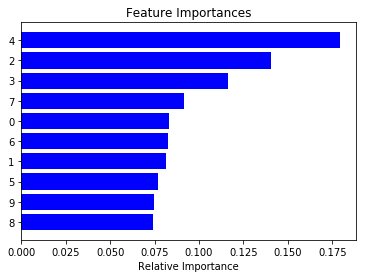

In [44]:
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.show()

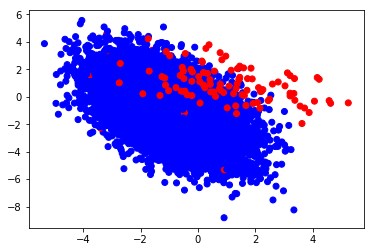

In [46]:
plt.scatter(feature[:,indices[-1]], feature[:,indices[-2]], c=label, cmap=plt.get_cmap('bwr'))
plt.show()